Ce notebook a pour objectif de créer un modèle prédictif du prix d'un appartement à partir des données Demandes de Valeurs Foncières (DVF) mises à disposition par le Ministère de l'Economie et des Finances.  
Les données viennent de https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/#resources

### Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from collections import Counter

from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor

In [2]:
np.set_printoptions(precision=4)

In [3]:
def metric_and_plot(preds, y_test, score=True):
    """
    Function that runs typical evaluation methods.
    Plot y_true vs y_pred
    Get score, R², MAE, MSE
    Parameters:
        - preds: model predictions
        - y_test: observations of the target variable in the test set
    """
    print(f"MAE : {metrics.mean_absolute_error(y_test, preds)}")
    print(f"MSE : {metrics.mean_squared_error(y_test, preds)}")
    if score:
        print(f"R² : {metrics.r2_score(y_test, preds)}")
    
    plt.scatter(preds, y_test)
    plt.xlabel("Prédictions (valeur foncière)")
    plt.ylabel("Valeur réelle (valeur foncière)")
    plt.title("Prédictions des valeurs foncières")
    plt.show()

### Convertir les .txt en .csv

In [4]:
fileList = os.listdir()
for filename in fileList:
    if ".txt" in filename:
        if filename[:-3]+"csv" in fileList:
            print(f"Conversion en csv déjà faite pour {filename}")
        else:
            print(f"Convert {filename} to csv")
            read_file = pd.read_csv(filename, sep='|')
            read_file.to_csv(filename[:-3]+"csv", index=None)

Conversion en csv déjà faite pour valeursfoncieres-2018.txt
Conversion en csv déjà faite pour valeursfoncieres-2019.txt
Conversion en csv déjà faite pour valeursfoncieres-2020.txt


### Chargement des données

In [5]:
csv2018 = pd.read_csv("valeursfoncieres-2018.csv")

C:\Users\Gremy Trullier\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (18,23,24,26,28,29,31,32,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
csv2019 = pd.read_csv("valeursfoncieres-2019.csv")

C:\Users\Gremy Trullier\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (18,23,24,26,28,29,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
csv2020 = pd.read_csv("valeursfoncieres-2020.csv")

C:\Users\Gremy Trullier\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Concatenation des données

Avant de fusionner les données des 3 années, il faut vérifier que les colonnes et les dtypes soient similaires.

In [8]:
csv2018.columns.all() == csv2019.columns.all() == csv2020.columns.all()
# columns are the same

True

In [9]:
csv2018.dtypes == csv2019.dtypes

Code service CH                True
Reference document             True
1 Articles CGI                 True
2 Articles CGI                 True
3 Articles CGI                 True
4 Articles CGI                 True
5 Articles CGI                 True
No disposition                 True
Date mutation                  True
Nature mutation                True
Valeur fonciere                True
No voie                        True
B/T/Q                          True
Type de voie                   True
Code voie                      True
Voie                           True
Code postal                    True
Commune                        True
Code departement               True
Code commune                   True
Prefixe de section             True
Section                        True
No plan                        True
No Volume                      True
1er lot                        True
Surface Carrez du 1er lot      True
2eme lot                       True
Surface Carrez du 2eme lot  

In [10]:
csv2018.dtypes == csv2020.dtypes

Code service CH                True
Reference document             True
1 Articles CGI                 True
2 Articles CGI                 True
3 Articles CGI                 True
4 Articles CGI                 True
5 Articles CGI                 True
No disposition                 True
Date mutation                  True
Nature mutation                True
Valeur fonciere                True
No voie                        True
B/T/Q                          True
Type de voie                   True
Code voie                      True
Voie                           True
Code postal                    True
Commune                        True
Code departement               True
Code commune                   True
Prefixe de section             True
Section                        True
No plan                        True
No Volume                      True
1er lot                        True
Surface Carrez du 1er lot      True
2eme lot                       True
Surface Carrez du 2eme lot  

In [11]:
csv2019.dtypes == csv2020.dtypes

Code service CH               True
Reference document            True
1 Articles CGI                True
2 Articles CGI                True
3 Articles CGI                True
4 Articles CGI                True
5 Articles CGI                True
No disposition                True
Date mutation                 True
Nature mutation               True
Valeur fonciere               True
No voie                       True
B/T/Q                         True
Type de voie                  True
Code voie                     True
Voie                          True
Code postal                   True
Commune                       True
Code departement              True
Code commune                  True
Prefixe de section            True
Section                       True
No plan                       True
No Volume                     True
1er lot                       True
Surface Carrez du 1er lot     True
2eme lot                      True
Surface Carrez du 2eme lot    True
3eme lot            

Les dtypes sont identiques sauf pour le 5eme lot (une colonne que nous allons retirer plus tard)

La concaténation

In [12]:
rawdf = pd.concat([csv2018, csv2019, csv2020])

In [13]:
len(rawdf)

10095093

In [14]:
len(rawdf) - rawdf.isnull().sum(axis=0) # absolute count of not nans rows

Code service CH                      0
Reference document                   0
1 Articles CGI                       0
2 Articles CGI                       0
3 Articles CGI                       0
4 Articles CGI                       0
5 Articles CGI                       0
No disposition                10095093
Date mutation                 10095093
Nature mutation               10095093
Valeur fonciere                9979638
No voie                        5950850
B/T/Q                           437788
Type de voie                   5814437
Code voie                      9999843
Voie                           9999774
Code postal                    9999447
Commune                       10095093
Code departement              10095093
Code commune                  10095093
Prefixe de section              462784
Section                       10094795
No plan                       10095093
No Volume                        28291
1er lot                        3139644
Surface Carrez du 1er lot

In [15]:
rawdf.isnull().sum(axis=0)/len(rawdf)*100 # percentage of nan values

Code service CH               100.000000
Reference document            100.000000
1 Articles CGI                100.000000
2 Articles CGI                100.000000
3 Articles CGI                100.000000
4 Articles CGI                100.000000
5 Articles CGI                100.000000
No disposition                  0.000000
Date mutation                   0.000000
Nature mutation                 0.000000
Valeur fonciere                 1.143674
No voie                        41.052054
B/T/Q                          95.663358
Type de voie                   42.403334
Code voie                       0.943528
Voie                            0.944211
Code postal                     0.947450
Commune                         0.000000
Code departement                0.000000
Code commune                    0.000000
Prefixe de section             95.415753
Section                         0.002952
No plan                         0.000000
No Volume                      99.719755
1er lot         

In [16]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10095093 entries, 0 to 3149481
Data columns (total 43 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Code service CH             float64
 1   Reference document          float64
 2   1 Articles CGI              float64
 3   2 Articles CGI              float64
 4   3 Articles CGI              float64
 5   4 Articles CGI              float64
 6   5 Articles CGI              float64
 7   No disposition              int64  
 8   Date mutation               object 
 9   Nature mutation             object 
 10  Valeur fonciere             object 
 11  No voie                     float64
 12  B/T/Q                       object 
 13  Type de voie                object 
 14  Code voie                   object 
 15  Voie                        object 
 16  Code postal                 float64
 17  Commune                     object 
 18  Code departement            object 
 19  Code commune        

Vérifier la cohérence des types et de la longueur du dataframe

In [17]:
print(len(csv2018), len(csv2019), len(csv2020), len(rawdf))
print(len(csv2018) + len(csv2019) + len(csv2020) - len(rawdf)) # check if number of rows is coherent

3332865 3612746 3149482 10095093
0


In [18]:
rawdf.columns == csv2018.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [19]:
rawdf.dtypes == csv2018.dtypes

Code service CH               True
Reference document            True
1 Articles CGI                True
2 Articles CGI                True
3 Articles CGI                True
4 Articles CGI                True
5 Articles CGI                True
No disposition                True
Date mutation                 True
Nature mutation               True
Valeur fonciere               True
No voie                       True
B/T/Q                         True
Type de voie                  True
Code voie                     True
Voie                          True
Code postal                   True
Commune                       True
Code departement              True
Code commune                  True
Prefixe de section            True
Section                       True
No plan                       True
No Volume                     True
1er lot                       True
Surface Carrez du 1er lot     True
2eme lot                      True
Surface Carrez du 2eme lot    True
3eme lot            

In [20]:
rawdf.head()

,Code service CH,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2018,Vente,...,NaN,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2018,Vente,...,NaN,2,2.0,Appartement,NaN,73.0,4.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,163.0,4.0,S,NaN,949.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,51.0,2.0,S,NaN,949.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2018,Vente,...,NaN,0,1.0,Maison,NaN,163.0,4.0,AG,JARD,420.0


#### Conversion des types

In [21]:
# convert text fields to categories
to_categorical = ['Type de voie', 'Type local',
                  'Nature culture', 'Nature culture speciale', 'Nature mutation', 'B/T/Q']
for colname in to_categorical:
    rawdf[colname] = rawdf[colname].astype('category')

In [22]:
rawdf.dtypes

Code service CH                float64
Reference document             float64
1 Articles CGI                 float64
2 Articles CGI                 float64
3 Articles CGI                 float64
4 Articles CGI                 float64
5 Articles CGI                 float64
No disposition                   int64
Date mutation                   object
Nature mutation               category
Valeur fonciere                 object
No voie                        float64
B/T/Q                         category
Type de voie                  category
Code voie                       object
Voie                            object
Code postal                    float64
Commune                         object
Code departement                object
Code commune                     int64
Prefixe de section             float64
Section                         object
No plan                          int64
No Volume                       object
1er lot                         object
Surface Carrez du 1er lot

In [23]:
rawdf.isnull().sum(axis=0)/len(rawdf)*100 # percentage of nan values

Code service CH               100.000000
Reference document            100.000000
1 Articles CGI                100.000000
2 Articles CGI                100.000000
3 Articles CGI                100.000000
4 Articles CGI                100.000000
5 Articles CGI                100.000000
No disposition                  0.000000
Date mutation                   0.000000
Nature mutation                 0.000000
Valeur fonciere                 1.143674
No voie                        41.052054
B/T/Q                          95.663358
Type de voie                   42.403334
Code voie                       0.943528
Voie                            0.944211
Code postal                     0.947450
Commune                         0.000000
Code departement                0.000000
Code commune                    0.000000
Prefixe de section             95.415753
Section                         0.002952
No plan                         0.000000
No Volume                      99.719755
1er lot         

In [24]:
# store dtypes for later use
finaltypes = rawdf.dtypes

In [25]:
finaltypes.to_dict()

{'Code service CH': dtype('float64'),
 'Reference document': dtype('float64'),
 '1 Articles CGI': dtype('float64'),
 '2 Articles CGI': dtype('float64'),
 '3 Articles CGI': dtype('float64'),
 '4 Articles CGI': dtype('float64'),
 '5 Articles CGI': dtype('float64'),
 'No disposition': dtype('int64'),
 'Date mutation': dtype('O'),
 'Nature mutation': CategoricalDtype(categories=['Adjudication', 'Echange', 'Expropriation', 'Vente',
                   'Vente en l'état futur d'achèvement',
                   'Vente terrain à bâtir'],
                  ordered=False),
 'Valeur fonciere': dtype('O'),
 'No voie': dtype('float64'),
 'B/T/Q': CategoricalDtype(categories=['*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6',
                   '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
                   'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
                   'V', 'W', 'X', 'Y', 'Z', 'b'],
                  ordered=False),
 'Type de voie': CategoricalDt

In [26]:
# reload and reconcat with appropriate dtypes
csv2018 = pd.read_csv("valeursfoncieres-2018.csv", dtype=finaltypes.to_dict(), parse_dates=['Date mutation'])
csv2019 = pd.read_csv("valeursfoncieres-2019.csv", dtype=finaltypes.to_dict(), parse_dates=['Date mutation'])
csv2020 = pd.read_csv("valeursfoncieres-2020.csv", dtype=finaltypes.to_dict(), parse_dates=['Date mutation'])
rawdf = pd.concat([csv2018, csv2019, csv2020])

In [27]:
rawdf.dtypes

Code service CH                      float64
Reference document                   float64
1 Articles CGI                       float64
2 Articles CGI                       float64
3 Articles CGI                       float64
4 Articles CGI                       float64
5 Articles CGI                       float64
No disposition                         int64
Date mutation                 datetime64[ns]
Nature mutation                     category
Valeur fonciere                       object
No voie                              float64
B/T/Q                               category
Type de voie                        category
Code voie                             object
Voie                                  object
Code postal                          float64
Commune                               object
Code departement                      object
Code commune                           int64
Prefixe de section                   float64
Section                               object
No plan   

In [28]:
rawdf.isnull().sum(axis=0)/len(rawdf)*100 # percentage of nan values

Code service CH               100.000000
Reference document            100.000000
1 Articles CGI                100.000000
2 Articles CGI                100.000000
3 Articles CGI                100.000000
4 Articles CGI                100.000000
5 Articles CGI                100.000000
No disposition                  0.000000
Date mutation                   0.000000
Nature mutation                 0.000000
Valeur fonciere                 1.143674
No voie                        41.052054
B/T/Q                          95.663358
Type de voie                   42.403334
Code voie                       0.943528
Voie                            0.944211
Code postal                     0.947450
Commune                         0.000000
Code departement                0.000000
Code commune                    0.000000
Prefixe de section             95.415753
Section                         0.002952
No plan                         0.000000
No Volume                      99.719755
1er lot         

In [29]:
rawdf.head()

,Code service CH,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2018-03-01,Vente,...,NaN,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2018-03-01,Vente,...,NaN,2,2.0,Appartement,NaN,73.0,4.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2018-04-01,Vente,...,NaN,0,1.0,Maison,NaN,163.0,4.0,S,NaN,949.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2018-04-01,Vente,...,NaN,0,1.0,Maison,NaN,51.0,2.0,S,NaN,949.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2018-04-01,Vente,...,NaN,0,1.0,Maison,NaN,163.0,4.0,AG,JARD,420.0


In [30]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10095093 entries, 0 to 3149481
Data columns (total 43 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Code service CH             float64       
 1   Reference document          float64       
 2   1 Articles CGI              float64       
 3   2 Articles CGI              float64       
 4   3 Articles CGI              float64       
 5   4 Articles CGI              float64       
 6   5 Articles CGI              float64       
 7   No disposition              int64         
 8   Date mutation               datetime64[ns]
 9   Nature mutation             category      
 10  Valeur fonciere             object        
 11  No voie                     float64       
 12  B/T/Q                       category      
 13  Type de voie                category      
 14  Code voie                   object        
 15  Voie                        object        
 16  Code postal      

In [31]:
# free some memory
del csv2018
del csv2019
del csv2020

### Nettoyage

In [32]:
rawdf.isnull().sum(axis=0)/len(rawdf)*100 # percentage of nan values

Code service CH               100.000000
Reference document            100.000000
1 Articles CGI                100.000000
2 Articles CGI                100.000000
3 Articles CGI                100.000000
4 Articles CGI                100.000000
5 Articles CGI                100.000000
No disposition                  0.000000
Date mutation                   0.000000
Nature mutation                 0.000000
Valeur fonciere                 1.143674
No voie                        41.052054
B/T/Q                          95.663358
Type de voie                   42.403334
Code voie                       0.943528
Voie                            0.944211
Code postal                     0.947450
Commune                         0.000000
Code departement                0.000000
Code commune                    0.000000
Prefixe de section             95.415753
Section                         0.002952
No plan                         0.000000
No Volume                      99.719755
1er lot         

In [33]:
# useful info about each column before cleaning
useful_info = pd.DataFrame.from_records([(col, rawdf[col].nunique(), rawdf[col].dtype, rawdf[col].isnull().sum(axis=0)/len(rawdf)*100) 
                                            for col in rawdf.columns],
                                          columns=['Column_Name', 'Num_Unique', 'Column_Dtype', 'Percentage of NaNs'])

In [34]:
useful_info

,Column_Name,Num_Unique,Column_Dtype,Percentage of NaNs
0,Code service CH,0,float64,100.000000
1,Reference document,0,float64,100.000000
2,1 Articles CGI,0,float64,100.000000
3,2 Articles CGI,0,float64,100.000000
4,3 Articles CGI,0,float64,100.000000
5,4 Articles CGI,0,float64,100.000000
6,5 Articles CGI,0,float64,100.000000
7,No disposition,694,int64,0.000000
8,Date mutation,1093,datetime64[ns],0.000000
9,Nature mutation,6,category,0.000000


In [35]:
# drop colummns with too many nans
drop_treshold = rawdf.shape[0]*0.4
cleandf = rawdf.dropna(thresh=drop_treshold, axis='columns').copy()

In [36]:
# drop all nans from Valeur foncière since it's the field we want to predict
cleandf.dropna(axis=0, subset=['Valeur fonciere'], inplace=True)

In [37]:
# drop all nans from Nombre pieces principales
cleandf.dropna(axis=0, subset=['Nombre pieces principales'], inplace=True)

In [38]:
# drop all nans from Surface reelle bati
cleandf.dropna(axis=0, subset=['Surface reelle bati'], inplace=True)

In [39]:
# drop all nans from remaining rows
cleandf.dropna(axis=0, inplace=True)

In [40]:
# these are numbers but should be considered as categories
to_categorical = ['No disposition', 'No voie', 'Code postal', 'Code commune', 'No plan', 'Code departement', 'Section']
for colname in to_categorical:
    cleandf[colname] = cleandf[colname].astype('category')

In [41]:
cleandf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2322257 entries, 2 to 3149480
Data columns (total 21 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   No disposition             category      
 1   Date mutation              datetime64[ns]
 2   Nature mutation            category      
 3   Valeur fonciere            object        
 4   No voie                    category      
 5   Type de voie               category      
 6   Code voie                  object        
 7   Voie                       object        
 8   Code postal                category      
 9   Commune                    object        
 10  Code departement           category      
 11  Code commune               category      
 12  Section                    category      
 13  No plan                    category      
 14  Nombre de lots             int64         
 15  Code type local            float64       
 16  Type local                 category 

In [42]:
len(cleandf['Valeur fonciere']), len(cleandf['Date mutation']), len(cleandf['Voie'])

(2322257, 2322257, 2322257)

In [43]:
useful_info_clean = pd.DataFrame.from_records([(col, cleandf[col].nunique(), cleandf[col].dtype, cleandf[col].isnull().sum(axis=0)/len(cleandf)*100) 
                                            for col in cleandf.columns],
                                          columns=['Column_Name', 'Num_Unique', 'Column_Dtype', 'Percentage of NaNs'])

In [44]:
useful_info_clean

,Column_Name,Num_Unique,Column_Dtype,Percentage of NaNs
0,No disposition,55,category,0.0
1,Date mutation,1051,datetime64[ns],0.0
2,Nature mutation,6,category,0.0
3,Valeur fonciere,96128,object,0.0
4,No voie,7547,category,0.0
5,Type de voie,137,category,0.0
6,Code voie,9710,object,0.0
7,Voie,231337,object,0.0
8,Code postal,5738,category,0.0
9,Commune,26966,object,0.0


In [45]:
# free some memory
del rawdf
del useful_info
del useful_info_clean

### Un peu d'exploration des données

### Champ à prédire

#### Valeur foncière
Il s’agit du montant ou de l’évaluation déclaré(e) dans le cadre d’une mutation à titre onéreux. La valeur foncière :  
inclut :  
    • les frais d’agence, s’ils sont à la charge du vendeur.  
    • l’éventuelle TVA.  
exclut :  
    • les frais d’agence, s’ils sont à la charge de l’acquéreur.  
    • les frais de notaires.  

In [46]:
cleandf['Valeur fonciere'].head()

2     239300,00
3     239300,00
4     239300,00
5     239300,00
22     47700,00
Name: Valeur fonciere, dtype: object

In [47]:
cleandf['Valeur fonciere'].dtype

dtype('O')

In [48]:
cleandf['Valeur fonciere'] = cleandf['Valeur fonciere'].str.replace(',', '.').astype(float)
cleandf['Valeur fonciere'].dtype

dtype('float64')

In [49]:
cleandf['Valeur fonciere'].describe()

count    2.322257e+06
mean     2.185093e+06
std      1.606789e+07
min      1.500000e-01
25%      1.230000e+05
50%      2.060000e+05
75%      3.697800e+05
max      1.249132e+09
Name: Valeur fonciere, dtype: float64

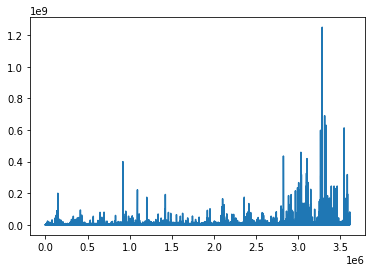

In [50]:
plt.plot(cleandf['Valeur fonciere'])

In [51]:
cleandf['Valeur fonciere'].describe()

count    2.322257e+06
mean     2.185093e+06
std      1.606789e+07
min      1.500000e-01
25%      1.230000e+05
50%      2.060000e+05
75%      3.697800e+05
max      1.249132e+09
Name: Valeur fonciere, dtype: float64

### Champs à utiliser pour prédire

#### Commune

In [52]:
cleandf['Commune'].head()

2     NIVIGNE ET SURAN
3     NIVIGNE ET SURAN
4     NIVIGNE ET SURAN
5     NIVIGNE ET SURAN
22                LENT
Name: Commune, dtype: object

#### Superficie

In [53]:
cleandf['Surface reelle bati'].head()

2     163.0
3      51.0
4     163.0
5      51.0
22    225.0
Name: Surface reelle bati, dtype: float64

In [54]:
cleandf['Surface reelle bati'].describe()

count    2.322257e+06
mean     1.209724e+02
std      7.201582e+02
min      0.000000e+00
25%      5.100000e+01
50%      8.400000e+01
75%      1.150000e+02
max      1.528560e+05
Name: Surface reelle bati, dtype: float64

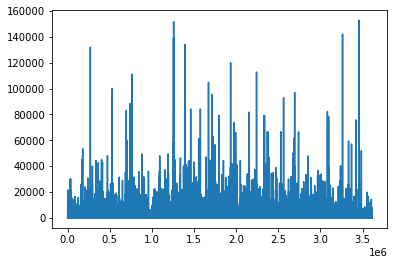

In [55]:
plt.plot(cleandf['Surface reelle bati'])

#### Nombre de pièces

In [56]:
cleandf['Nombre pieces principales'].head()

2     4.0
3     2.0
4     4.0
5     2.0
22    5.0
Name: Nombre pieces principales, dtype: float64

In [57]:
cleandf['Nombre pieces principales'].describe()

count    2.322257e+06
mean     3.258858e+00
std      2.111434e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      1.090000e+02
Name: Nombre pieces principales, dtype: float64

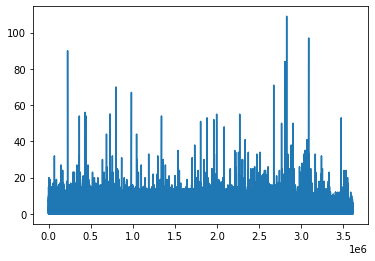

In [58]:
plt.plot(cleandf['Nombre pieces principales'])

#### Année de transaction

In [59]:
print(cleandf['Date mutation'].dtype)
cleandf['Date mutation'].head()

datetime64[ns]


2    2018-04-01
3    2018-04-01
4    2018-04-01
5    2018-04-01
22   2018-08-01
Name: Date mutation, dtype: datetime64[ns]

### Dataframe avec seulement les paramètres minimum pour voir les performances de base

In [60]:
columns = ['Valeur fonciere', 'Date mutation', 'Code commune', 'Nombre pieces principales', 'Surface reelle bati']
minimaldf = pd.DataFrame(cleandf, columns=columns)

In [61]:
minimaldf['Annee transaction'] = minimaldf['Date mutation'].apply(lambda x: x.year)

In [62]:
minimaldf.head()

,Valeur fonciere,Date mutation,Code commune,Nombre pieces principales,Surface reelle bati,Annee transaction
2,239300.0,2018-04-01,95,4.0,163.0,2018
3,239300.0,2018-04-01,95,2.0,51.0,2018
4,239300.0,2018-04-01,95,4.0,163.0,2018
5,239300.0,2018-04-01,95,2.0,51.0,2018
22,47700.0,2018-08-01,211,5.0,225.0,2018


In [63]:
minimaldf.drop(['Date mutation'], axis='columns', inplace=True)
minimaldf.head()

,Valeur fonciere,Code commune,Nombre pieces principales,Surface reelle bati,Annee transaction
2,239300.0,95,4.0,163.0,2018
3,239300.0,95,2.0,51.0,2018
4,239300.0,95,4.0,163.0,2018
5,239300.0,95,2.0,51.0,2018
22,47700.0,211,5.0,225.0,2018


In [97]:
(minimaldf.columns)

Index(['Valeur fonciere', 'Code commune', 'Nombre pieces principales',
       'Surface reelle bati', 'Annee transaction'],
      dtype='object')

In [98]:
X_train_min.columns

Index(['Code commune', 'Nombre pieces principales', 'Surface reelle bati',
       'Annee transaction'],
      dtype='object')

In [64]:
minimaldf['Valeur fonciere'].describe()

count    2.322257e+06
mean     2.185093e+06
std      1.606789e+07
min      1.500000e-01
25%      1.230000e+05
50%      2.060000e+05
75%      3.697800e+05
max      1.249132e+09
Name: Valeur fonciere, dtype: float64

In [65]:
minimaldf['Valeur fonciere'].value_counts()

150000.0    25449
100000.0    22941
120000.0    22457
200000.0    22213
160000.0    19967
            ...  
580290.0        1
580277.0        1
580160.0        1
580150.0        1
473350.0        1
Name: Valeur fonciere, Length: 96128, dtype: int64

### Dataframe avec les colonnes intéressantes

In [66]:
columns = ['Valeur fonciere', 'Date mutation', 'Code commune', 'Nombre pieces principales', 'Surface reelle bati',
           'Nature mutation', 'Type de voie', 'Code departement', 'Type local', 'Nature culture']
df = pd.DataFrame(cleandf, columns=columns)

In [67]:
df.head()

,Valeur fonciere,Date mutation,Code commune,Nombre pieces principales,Surface reelle bati,Nature mutation,Type de voie,Code departement,Type local,Nature culture
2,239300.0,2018-04-01,95,4.0,163.0,Vente,RUE,1,Maison,S
3,239300.0,2018-04-01,95,2.0,51.0,Vente,RUE,1,Maison,S
4,239300.0,2018-04-01,95,4.0,163.0,Vente,RUE,1,Maison,AG
5,239300.0,2018-04-01,95,2.0,51.0,Vente,RUE,1,Maison,AG
22,47700.0,2018-08-01,211,5.0,225.0,Vente,RTE,1,Maison,S


Encodage des categories

In [68]:
df.dtypes

Valeur fonciere                     float64
Date mutation                datetime64[ns]
Code commune                       category
Nombre pieces principales           float64
Surface reelle bati                 float64
Nature mutation                    category
Type de voie                       category
Code departement                   category
Type local                         category
Nature culture                     category
dtype: object

In [69]:
#https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b#:~:text=A%20categorical%20feature%20is%20said,absence)%20in%20the%20categorical%20variable.

def cumulatively_categorise(column,threshold=0.95,return_categories_list=True):
    """
    Function that create categories and merges categories that are low represented in the dataset into 'Other' categories
    Parameters:
        - column: the column to encode
        - threshold: threshold for the 'Other' category. Float between 0 and 1, defaults to 0.95
        - return_categories_list: to return the list of categories created or not. Boolean, defaults to True
    """
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: x if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list
    #Return only the transformed column if return_categories=False
    else:
        return new_column

Convertir 'Type de voie' et 'Nature culture'

In [70]:
transformed_column, new_category_list = cumulatively_categorise(df['Type de voie'],return_categories_list=True)

In [71]:
df['Type de voie trans'] = transformed_column

In [72]:
transformed_column, new_category_list = cumulatively_categorise(df['Nature culture'],return_categories_list=True)

In [73]:
df['Nature culture trans'] = transformed_column

In [74]:
df.drop(columns=['Type de voie', 'Nature culture'],inplace=True)

In [75]:
df.head()

,Valeur fonciere,Date mutation,Code commune,Nombre pieces principales,Surface reelle bati,Nature mutation,Code departement,Type local,Type de voie trans,Nature culture trans
2,239300.0,2018-04-01,95,4.0,163.0,Vente,1,Maison,RUE,S
3,239300.0,2018-04-01,95,2.0,51.0,Vente,1,Maison,RUE,S
4,239300.0,2018-04-01,95,4.0,163.0,Vente,1,Maison,RUE,AG
5,239300.0,2018-04-01,95,2.0,51.0,Vente,1,Maison,RUE,AG
22,47700.0,2018-08-01,211,5.0,225.0,Vente,1,Maison,RTE,S


Encodage One Hot des catégories à faible cardinalité

In [76]:
OHencoder = ce.OneHotEncoder(cols=['Nature mutation', 'Type local', 'Nature culture trans', 'Type de voie trans'], return_df=True)

In [77]:
df = OHencoder.fit_transform(df)

Encodage Base N des catégories à forte cardinalité

In [78]:
bn_enc = ce.BaseNEncoder(cols=['Code commune', 'Code departement'],return_df=True,base=10)

In [79]:
df = bn_enc.fit_transform(df)

In [80]:
df.head()

,Valeur fonciere,Date mutation,Code commune_0,Code commune_1,Code commune_2,Nombre pieces principales,Surface reelle bati,Nature mutation_1,Nature mutation_2,Nature mutation_3,...,Type de voie trans_6,Type de voie trans_7,Type de voie trans_8,Type de voie trans_9,Type de voie trans_10,Type de voie trans_11,Nature culture trans_1,Nature culture trans_2,Nature culture trans_3,Nature culture trans_4
2,239300.0,2018-04-01,0,0,1,4.0,163.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,239300.0,2018-04-01,0,0,1,2.0,51.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,239300.0,2018-04-01,0,0,1,4.0,163.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,239300.0,2018-04-01,0,0,1,2.0,51.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
22,47700.0,2018-08-01,0,0,2,5.0,225.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Conversion de la date en année

In [81]:
df['Annee transaction'] = df['Date mutation'].apply(lambda x: x.year)

In [82]:
df.drop(columns=['Date mutation'], inplace=True)

In [83]:
df.dtypes

Valeur fonciere              float64
Code commune_0                 int64
Code commune_1                 int64
Code commune_2                 int64
Nombre pieces principales    float64
Surface reelle bati          float64
Nature mutation_1              int64
Nature mutation_2              int64
Nature mutation_3              int64
Nature mutation_4              int64
Nature mutation_5              int64
Nature mutation_6              int64
Code departement_0             int64
Code departement_1             int64
Type local_1                   int64
Type local_2                   int64
Type local_3                   int64
Type local_4                   int64
Type de voie trans_1           int64
Type de voie trans_2           int64
Type de voie trans_3           int64
Type de voie trans_4           int64
Type de voie trans_5           int64
Type de voie trans_6           int64
Type de voie trans_7           int64
Type de voie trans_8           int64
Type de voie trans_9           int64
T

In [84]:
stop

NameError: name 'stop' is not defined

### Preprocessing

#### Encodage des variables categorielles

#### Get dummies (équivalent au One Hot Encoding)

In [ ]:
dummy_df = pd.get_dummies(minimaldf, drop_first=True, sparse=True)

In [ ]:
dummy_df.info()

In [ ]:
dummy_df.head()

#### Hash encoding

In [ ]:
hash_enc = ce.HashingEncoder(cols=['Code commune'], return_df=True,n_components=32)

In [ ]:
hashdf = hash_enc.fit_transform(minimaldf)

In [ ]:
hashdf.info()

In [ ]:
hashdf.head()

#### Binary Encoding

In [ ]:
bin_enc = ce.BinaryEncoder(cols=['Code commune'], return_df=True)

In [ ]:
bindf = bin_enc.fit_transform(minimaldf)

In [ ]:
bindf.info()

In [ ]:
bindf.head()

#### Base N encoding

In [ ]:
bn_enc = ce.BaseNEncoder(cols=['Code commune', 'Code departement'],return_df=True,base=10)

In [ ]:
df = bn_enc.fit_transform(df)

In [ ]:
bndf.info()

In [ ]:
bndf.head()

### Séparation en training et test set

Avec le DataFrame enrichi des paramètres utiles

In [85]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [86]:
y_train = train.pop('Valeur fonciere')
X_train = train

In [87]:
y_test = test.pop('Valeur fonciere')
X_test = test

Avec le DataFrame minimal

In [88]:
mintrain, mintest = train_test_split(minimaldf, test_size=0.2, random_state=42, shuffle=True)

In [89]:
y_train_min = mintrain.pop('Valeur fonciere')
X_train_min = mintrain

In [90]:
y_test_min = mintest.pop('Valeur fonciere')
X_test_min = mintest

In [99]:
X_test_min.columns

Index(['Code commune', 'Nombre pieces principales', 'Surface reelle bati',
       'Annee transaction'],
      dtype='object')

### Modèle prédictif

In [91]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1857805 entries, 1360189 to 2671655
Data columns (total 33 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Code commune_0             int64  
 1   Code commune_1             int64  
 2   Code commune_2             int64  
 3   Nombre pieces principales  float64
 4   Surface reelle bati        float64
 5   Nature mutation_1          int64  
 6   Nature mutation_2          int64  
 7   Nature mutation_3          int64  
 8   Nature mutation_4          int64  
 9   Nature mutation_5          int64  
 10  Nature mutation_6          int64  
 11  Code departement_0         int64  
 12  Code departement_1         int64  
 13  Type local_1               int64  
 14  Type local_2               int64  
 15  Type local_3               int64  
 16  Type local_4               int64  
 17  Type de voie trans_1       int64  
 18  Type de voie trans_2       int64  
 19  Type de voie trans_3       int64  
 

On essaye plusieurs modèles différents

#### Linear Regression

In [ ]:
reg = linear_model.LinearRegression()

In [ ]:
reg.fit(X_train, y_train)

In [ ]:
preds = reg.predict(X_test)

In [ ]:
score = reg.score(X_test, y_test)

In [ ]:
score

In [ ]:
reg.coef_

In [ ]:
reg.intercept_

In [ ]:
print("LINEAR REGRESSOR")
metric_and_plot(preds, y_test)

#### Lasso

In [ ]:
lasso = linear_model.Lasso(alpha=0.1, random_state=42)

In [ ]:
lasso.fit(X_train, y_train)

In [ ]:
lassopreds = lasso.predict(X_test)

In [ ]:
score = lasso.score(X_test, y_test)

In [ ]:
score

In [ ]:
print("LASSO REGRESSOR")
metric_and_plot(lassopreds, y_test)

#### Elastic

In [ ]:
elastic = linear_model.ElasticNet(random_state=42)
elastic.fit(X_train, y_train)

In [ ]:
elasticpreds = elastic.predict(X_test)

In [ ]:
score = elastic.score(X_test, y_test)

In [ ]:
score

In [ ]:
print("ELASTIC NET REGRESSOR")
metric_and_plot(elasticpreds, y_test)

#### MLP Regressor

In [ ]:
mlpreg = MLPRegressor(random_state=42).fit(X_train, y_train)

In [ ]:
mlppreds = mlpreg.predict(X_test)

In [ ]:
mlpreg.score(X_test, y_test)

In [ ]:
print("MLP REGRESSOR")
metric_and_plot(mlppreds, y_test)

#### AdaBoostRegressor

In [ ]:
adareg = AdaBoostRegressor(random_state=42)

In [ ]:
adareg.fit(X_train, y_train)

In [ ]:
adapreds = adareg.predict(X_test)

In [ ]:
adareg.score(X_test, y_test)

In [ ]:
print("ADABOOST REGRESSOR")
metric_and_plot(adapreds, y_test)

#### BaggingRegressor

In [92]:
bagreg = BaggingRegressor(n_estimators=20, random_state=42)

In [93]:
bagreg.fit(X_train, y_train)

BaggingRegressor(n_estimators=20, random_state=42)

In [94]:
bagpreds = bagreg.predict(X_test)

In [95]:
bagreg.score(X_test, y_test)

0.7105468978646521

BAGGING REGRESSOR
MAE : 658390.828244824
MSE : 75876288201653.8
R² : 0.7105468978646521


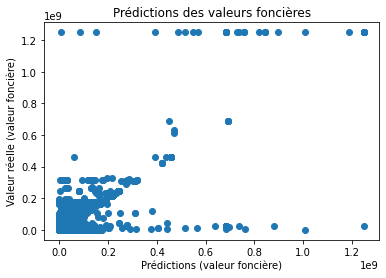

In [96]:
print("BAGGING REGRESSOR")
metric_and_plot(bagpreds, y_test)

In [103]:
X_test_min.head()

,Code commune,Nombre pieces principales,Surface reelle bati,Annee transaction
2514437,101,0.0,0.0,2020
3199232,351,3.0,61.0,2018
771353,321,3.0,61.0,2019
229094,409,5.0,110.0,2019
3197244,345,4.0,62.0,2019


In [102]:
superficiy = 50
code_commune = 75018
annee = 2020
nb_piece = 2

In [104]:
arr = np.array([75018, 2, 50, 2020])

In [107]:
rfreg.predict([arr])

NameError: name 'rfreg' is not defined

In [100]:
minimaldf['Code commune'].unique()

[95, 211, 430, 123, 53, ..., 891, 834, 840, 877, 883]
Length: 908
Categories (908, int64): [95, 211, 430, 123, ..., 834, 840, 877, 883]

#### RandomForestRegressor

In [ ]:
rfreg = RandomForestRegressor(random_state=42)

In [ ]:
rfreg.fit(X_train_min, y_train_min)

In [ ]:
rfpreds = rfreg.predict(X_test_min)

In [ ]:
print("RANDOM FOREST REGRESSOR")
metric_and_plot(rfpreds, y_test_min, score=False)

#### TransformedTargetRegressor

In [ ]:
ttreg = TransformedTargetRegressor(regressor=linear_model.RidgeCV(),
                                   transformer=preprocessing.QuantileTransformer(n_quantiles=1000, 
                                                                                 output_distribution='normal',
                                                                                 random_state=42),
                                  )

In [ ]:
ttreg.fit(X_train_min, y_train_min)

In [ ]:
ttreg.score(X_test_min, y_test_min)

In [ ]:
ttpreds = ttreg.predict(X_test_min)

In [ ]:
print("TRANSFORMED TARGET REGRESSOR")
metric_and_plot(ttpreds, y_test_min)

Avec une transformation logarithmique

In [ ]:
ttreg = TransformedTargetRegressor(regressor=linear_model.RidgeCV(),
                                   func=np.log, inverse_func=np.exp
                                  )

In [ ]:
ttreg.fit(X_train_min, y_train_min)

In [ ]:
ttreg.score(X_test_min, y_test_min)

In [ ]:
ttpreds = ttreg.predict(X_test_min)

In [ ]:
print("TRANSFORMED TARGET REGRESSOR")
metric_and_plot(ttpreds, y_test_min)

### Evaluation des performances (voir metric_and_plot() plus haut)

In [ ]:
plt.scatter(preds, y_test)
plt.xlabel("Prédictions (valeur foncière)")
plt.ylabel("Valeur réelle (valeur foncière)")
plt.title("Prédictions des valeurs foncières")

In [ ]:
metrics.mean_absolute_error(y_test, preds)

In [ ]:
metrics.mean_squared_error(y_test, preds)

In [ ]:
metrics.mean_squared_log_error(y_test, bagpreds)

In [ ]:
metrics.r2_score(y_test, preds)